In [1]:
# Create new multi-modal edges that link road, rail and maritime network interchange nodes
# Combine networks into one, with unified schema
# Add destination country nodes 
# Duplicate, reverse and append all intermodal, road and rail edges (to match maritime)

In [2]:
import os

import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import pyproj
from scipy.spatial import cKDTree
from shapely.geometry import LineString
from shapely.ops import linemerge
from tqdm import tqdm

plt.style.use("dark_background")

In [3]:
def duplicate_reverse_and_append_edges(edges: pd.DataFrame) -> pd.DataFrame:
    """
    Given edges with `from_id`, `to_id`, `from_iso_a3` and `to_iso_a3` columns,
    create duplicate edges with direction reversed.

    Args:
        edges: Table of edges to reverse and append to

    Returns:
        Table consisting of original edges and their reversed duplicates.
    """
    reversed_edges = edges.copy()
    reversed_edges.from_id = edges.to_id
    reversed_edges.to_id = edges.from_id
    reversed_edges.from_iso_a3 = edges.to_iso_a3
    reversed_edges.to_iso_a3 = edges.from_iso_a3
    return pd.concat([edges, reversed_edges])

In [4]:
def preprocess_road_rail_network(
    nodes_path: str,
    edges_path: str,
    mode: str,
    cost_USD_t_km: float,
    directional: float
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Preprocess road or rail network data into a suitable format for multi-modal routing.
    Find length of edges, calculate cost. Relabel IDs to include mode so they're unique across networks.
    
    Args:
        nodes_path: Path to nodes geoparquet file on disk
        edges_path: Path to edges geoparquet file on disk
        mode: Transport mode categorical string to store under edges["mode"]
        cost_USD_t_km: Cost of transporting goods in USD per tonne km
        directional: Whether to duplicate, reverse and append edges (from_id and to_id switched)

    Returns:
        Nodes and edges as two GeoDataFrames.
    """

    edges = gpd.read_parquet(edges_path)
    edges["mode"] = mode
    edges["cost_USD_t_km"] = cost_USD_t_km
    edges["distance_km"] = edges.geometry.to_crs(edges.estimate_utm_crs()).length / 1_000
    edges["cost_USD_t"] = edges["cost_USD_t_km"] * edges["distance_km"]
    edges["id"] = edges.apply(lambda row: f"{row['mode']}_{row['id']}", axis=1)
    edges["to_id"] = edges.apply(lambda row: f"{row['mode']}_{row['to_id']}", axis=1)
    edges["from_id"] = edges.apply(lambda row: f"{row['mode']}_{row['from_id']}", axis=1)

    if directional:
        edges = duplicate_reverse_and_append_edges(edges)
    
    nodes = gpd.read_parquet(nodes_path)
    nodes["mode"] = mode
    nodes["id"] = nodes.apply(lambda row: f"{row['mode']}_{row['id']}", axis=1)

    return nodes, edges

In [5]:
def preprocess_maritime_network(nodes_path: str, edges_path: str) -> tuple[gpd.GeoDataFrame, pd.DataFrame]:
    """
    Preprocess maritime network data into a suitable format for multi-modal routing.
    Relabel IDs so they're unique across networks.
    
    Args:
        nodes_path: Path to nodes geoparquet file on disk
        edges_path: Path to edges parquet file on disk

    Returns:
        Nodes GeoDataFrame and edges DataFrame.
    """
    edges = pd.read_parquet(edges_path).rename(columns={"from_iso3": "from_iso_a3", "to_iso3": "to_iso_a3"})
    edges["mode"] = "maritime"
    edges["cost_USD_t"] = edges["distance_km"] * edges["cost_USD_t_km"]
    
    nodes = gpd.read_parquet(nodes_path)
    nodes = nodes.rename(columns={"iso3": "iso_a3"})
    nodes = nodes.drop(columns=["Continent_Code"])
    ports_mask = nodes.infra == "port"

    # we want to connect our road and rail nodes to the port_land node of the port_in, port_out, port_land trifecta
    nodes.loc[ports_mask, "id"] = nodes.loc[ports_mask, :].apply(lambda row: f"{row.id}_land", axis=1)

    return nodes, edges

In [6]:
def find_nearest_points(
    a: gpd.GeoDataFrame,
    b: gpd.GeoDataFrame,
    b_id_col: str,
) -> gpd.GeoDataFrame:
    """
    Given two GeoDataFrames of point locations, `a` and `b`, for each point in `a`, find the closest in `b`.

    Modified from:
    https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

    a: Table of points to start from, we run over every row here
    b: Table of candidate closest points
    b_id_col: Name of column in b identifying points

    Returns:
        `a`, joined with the values from `b_id_col` from the points of `b` which are closest
    """

    # find nearest point in b for each and every point in a
    tree = cKDTree(b.geometry.get_coordinates().to_numpy())
    distances, indicies = tree.query(a.geometry.get_coordinates().to_numpy(), k=1)
    nearest_points = b.iloc[indicies][[b_id_col, "geometry"]] \
        .reset_index(drop=True).rename(columns={"geometry": "nearest_node_geometry"})
    
    return pd.concat(
        [
            a.reset_index(drop=True),
            nearest_points,
            pd.Series(data=distances, name='distance')
        ], 
        axis=1
    )

In [7]:
def create_edges_to_nearest_nodes(
    a: gpd.GeoDataFrame,
    b: gpd.GeoDataFrame,
    max_distance_m: float,
    projected_coordinate_system: pyproj.crs.crs.CRS,
) -> gpd.GeoDataFrame:
    """
    Given two sets of nodes, a and b, loop through nodes in a, finding the closest 
    node in b (which is less than `max_distance_m` away). Create a linear linestring
    connecting these points.

    Args:
        a: Table of nodes to connect from, containing GeoSeries of point locations.
            Must contain "id", "iso_a3" and "geometry" columns.
        b: Table of candidate notes to connect to, containing Geoseries of point locations.
            Must contain "id" and "geometry" columns.
        max_distance_m: Edges only created if their span in metres is equal to or less than this value.
        projected_coordinate_system: Project points to this CRS (must use metres!) before estimating distances.

    Returns:
        Table of linking edges.
    """
    
    point_pairs = find_nearest_points(
        a.to_crs(projected_coordinate_system),
        b.to_crs(projected_coordinate_system).rename(columns={"id": "nearest_node_id"}),
        "nearest_node_id"
    ).rename(columns={"distance": "distance_m"})

    point_pairs = point_pairs[point_pairs.distance_m < max_distance_m]

    edges = point_pairs.apply(
        lambda row: {
            "from_id": row.id,
            "to_id": row.nearest_node_id,
            "from_iso_a3": row.iso_a3,
            "to_iso_a3": row.iso_a3,  # assume link does not cross a border
            "geometry": LineString([row.geometry, row.nearest_node_geometry]),
            "distance_m": row.distance_m
        },
        axis=1,
        result_type="expand"
    )
    
    return gpd.GeoDataFrame(edges).reset_index(drop=True).set_crs(projected_coordinate_system)

In [8]:
def find_importing_node_id(row: pd.Series, exporting_country: str) -> str:
    """
    Return the node id lying in the importing country

    Args:
        row: Table row with columns from_iso_a3, to_iso_a3, from_id and to_id
        exporting_country: ISO A3 code of exporting country

    Returns
        node id
    """
    if row.from_iso_a3 == exporting_country and row.to_iso_a3 != exporting_country:
        return row.to_id
    elif row.from_iso_a3 != exporting_country and row.to_iso_a3 == exporting_country:
        return row.from_id
    else:
        raise RuntimeError

In [9]:
def create_edges_to_destination_countries(
    origin_nodes: gpd.GeoDataFrame,
    destination_country_nodes: gpd.GeoDataFrame,
    cost_USD_t: float = 1E6,
) -> gpd.GeoDataFrame:
    """
    Create edges between nodes within the same country of zero cost.

    Args:
        origin_nodes: Table of origin nodes to create edges from
        destination_country_nodes: Table of destination nodes to connect to, one per country
        cost_USD_t: Cost of traversing this edge, in USD per tonne. Defaults to a very high 
            value, so that route allocations will only use these edges as a final connection 
            to the destination, rather than a general means of traversal. 

    Returns:
        Table of edges of same length as origin_nodes, connecting these to destination_country_nodes
    """

    assert len(destination_country_nodes.iso_a3) == len(destination_country_nodes.iso_a3.unique())
    assert origin_nodes.crs == destination_country_nodes.crs

    def make_edge(row: pd.Series) -> dict:
        destination = destination_country_nodes.set_index("iso_a3").loc[row.iso_a3]
        return {
            "from_id": row.id,
            "to_id": destination.id,
            "from_iso_a3": row.iso_a3,
            "to_iso_a3": row.iso_a3,
            "mode": "imaginary",
            "geometry": LineString(
                [
                    row.geometry,
                    destination.geometry
                ]
            ),
            "cost_USD_t": cost_USD_t
        }

    edges = origin_nodes.apply(
        make_edge,
        axis=1,
        result_type="expand"
    )
    
    return gpd.GeoDataFrame(edges).reset_index(drop=True).set_crs(origin_nodes.crs)

In [10]:
def path_edges_from_ordered_id_list(path_node_ids: list[str], edges: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    If `path_node_ids` are sequential nodes forming a path through a graph made of `edges`,
    return the subset of ordered edges connecting these nodes.

    Args:
        path_node_ids: Sequential node ids of some path through graph
        edges: Set of edges containing possible path edges

    Returns:
        Ordered subset of `edges` corresponding to path prescribed by `path_node_ids`
    """
    route_edges = []
    for i, from_node_id in enumerate(path_node_ids[:-1]):
        to_node_id = path_node_ids[i + 1]
        edge = edges[(edges.from_id == from_node_id) & (edges.to_id == to_node_id)]
        assert len(edge) == 1
        route_edges.append(edge)
    return pd.concat(route_edges)

In [11]:
# read network data from disk and preprocess

study_country = "THA"
root_dir = ".."

road_nodes, road_edges = preprocess_road_rail_network(
    os.path.join(root_dir, "results/composite_network/south-east-asia-road/nodes.gpq"),
    os.path.join(root_dir, "results/composite_network/south-east-asia-road/edges.gpq"),
    "road",
    0.1,  # 0.03 - 0.35 USD / (t km) a plausible range
    True
)

rail_nodes, rail_edges = preprocess_road_rail_network(
    os.path.join(root_dir, "results/composite_network/south-east-asia-rail/nodes.gpq"),
    os.path.join(root_dir, "results/composite_network/south-east-asia-rail/edges.gpq"),
    "rail",
    0.06, # 0.03 - 0.12 USD / (t km) a plausible range
    True
)

# possible cargo types = ("container", "dry_bulk", "general_cargo",  "roro", "tanker")
# for now, just use 'general_cargo'
maritime_nodes, maritime_edges_no_geom = preprocess_maritime_network(
    os.path.join(root_dir, "results/input/maritime/nodes.gpq"),
    os.path.join(root_dir, "results/input/maritime/edges_by_cargo/maritime_base_network_general_cargo.pq")
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77862/77862 [1:01:29<00:00, 21.10it/s]


<Axes: >

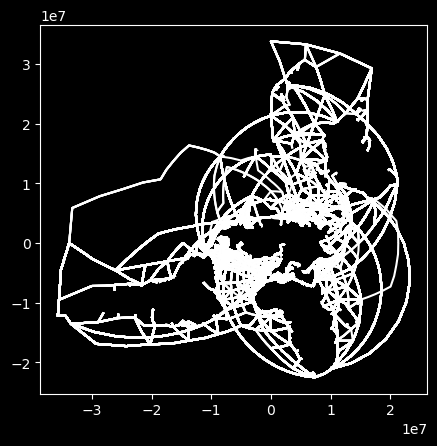

In [12]:
# Jasper's maritime edges in 'edges_by_cargo' do not contain geometry, only weights
# this is a pain for visualisation, so we will create a geometry for each from `maritime_vis_edges`
# this will take ~1hr

maritime_vis_edges = gpd.read_parquet(os.path.join(root_dir, "results/input/maritime/edges.gpq"))
vis_graph = nx.Graph()
vis_graph.add_nodes_from(maritime_nodes.id)
vis_graph.add_weighted_edges_from(maritime_vis_edges.loc[:, ["from_id", "to_id", "distance"]].values)

maritime_edges = maritime_edges_no_geom.copy()
change_of_port_mask = maritime_edges_no_geom.from_port != maritime_edges_no_geom.to_port
port_pairs_to_generate_geom_for = maritime_edges_no_geom[change_of_port_mask]
for index, row in tqdm(port_pairs_to_generate_geom_for.iterrows(), total=len(port_pairs_to_generate_geom_for)):
    path_node_ids = nx.bellman_ford_path(vis_graph, row.from_port, row.to_port, "distance")
    path_edges = path_edges_from_ordered_id_list(path_node_ids, maritime_vis_edges)
    path_linestring = linemerge(list(path_edges.geometry))
    maritime_edges.loc[index, "geometry"] = path_linestring

maritime_edges = gpd.GeoDataFrame(maritime_edges).set_crs(epsg=4326)
maritime_edges.to_crs(epsg=3995).plot()

In [13]:
# create intermodal connections

maximum_intermodal_connection_metres = 2_000

# road-rail
rail_road_edges = create_edges_to_nearest_nodes(
    rail_nodes.loc[rail_nodes.station == True, ["id", "iso_a3", "geometry"]],
    road_nodes.loc[:, ["id", "geometry"]],
    maximum_intermodal_connection_metres,
    rail_nodes.estimate_utm_crs()
).to_crs(epsg=4326)
rail_road_edges["mode"] = "road_rail"

# road-maritime
maritime_road_edges = create_edges_to_nearest_nodes(
    maritime_nodes.loc[
        (maritime_nodes.infra == "port") & (maritime_nodes.iso_a3 == study_country),
        ["id", "iso_a3", "geometry"]
    ],
    road_nodes.loc[:, ["id", "geometry"]],
    maximum_intermodal_connection_metres,
    road_nodes.estimate_utm_crs()
).to_crs(epsg=4326)
maritime_road_edges["mode"] = "maritime_road"

# rail-maritime
maritime_rail_edges = create_edges_to_nearest_nodes(
    maritime_nodes.loc[
        (maritime_nodes.infra == "port") & (maritime_nodes.iso_a3 == study_country),
        ["id", "iso_a3", "geometry"]
    ],
    rail_nodes.loc[rail_nodes.station == True, ["id", "geometry"]],
    maximum_intermodal_connection_metres,
    road_nodes.estimate_utm_crs()
).to_crs(epsg=4326)
maritime_rail_edges["mode"] = "maritime_rail"

intermodal_edges = pd.concat(
    [
        rail_road_edges,
        maritime_road_edges,
        maritime_rail_edges
    ]
)
# as the maritime edges are directional, we're making road, rail and intermodal directional too (so duplicate)
intermodal_edges = duplicate_reverse_and_append_edges(intermodal_edges)

# from mistral/ccg-critical-minerals/processed_data/transport_costs/intermodal.xlsx, 20240611
intermodal_cost_USD_t = {
    "road_rail": 5,
    "maritime_road": 4,
    "maritime_rail": 5,
}
intermodal_edges["cost_USD_t"] = intermodal_edges["mode"].map(intermodal_cost_USD_t)

In [14]:
# concatenate different kinds of nodes and edges

node_cols = ["id", "iso_a3", "geometry"]
nodes = gpd.GeoDataFrame(
    pd.concat(
        [
            road_nodes.loc[:, node_cols],
            rail_nodes.loc[:, node_cols],
            maritime_nodes.loc[:, node_cols]
        ]
    ),
    crs=4326
)

edge_cols = ["from_id", "to_id", "from_iso_a3", "to_iso_a3", "mode", "cost_USD_t", "geometry"]
edges = pd.concat(
    [
        intermodal_edges.loc[:, edge_cols],
        road_edges.loc[:, edge_cols],
        rail_edges.loc[:, edge_cols],
        maritime_edges.loc[:, edge_cols]
    ]
)

In [15]:
# add nodes for destination countries (not null, not origin country)
# neighbouring countries will have destination node connected to border crossings

countries = nodes.iso_a3.unique()
countries = countries[countries != np.array(None)]
countries = set(countries)
countries.remove(study_country)

admin_boundaries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
country_nodes = admin_boundaries.set_index("GID_0").loc[list(countries), ["geometry"]] \
    .sort_index().reset_index().rename(columns={"GID_0": "iso_a3"})
country_nodes["id"] = country_nodes.apply(lambda row: f"GID_0_{row.iso_a3}", axis=1)
country_nodes.geometry = country_nodes.geometry.representative_point()
destination_country_nodes = country_nodes.loc[:, ["id", "iso_a3", "geometry"]]

nodes = pd.concat(
    [
        nodes,
        destination_country_nodes
    ]
)

<Axes: >

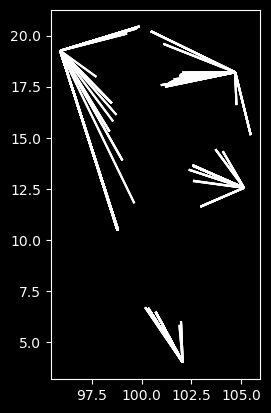

In [16]:
# find nodes which lie on far side of border crossing

border_crossing_mask = \
    (edges.from_iso_a3 != edges.to_iso_a3) \
    & ((edges.from_iso_a3 == study_country) | (edges.to_iso_a3 == study_country)) \
    & ((edges["mode"] == "road") | (edges["mode"] == "rail")) \
    
importing_node_ids = edges[border_crossing_mask].apply(find_importing_node_id, exporting_country=study_country, axis=1)
importing_nodes = nodes.set_index("id").loc[importing_node_ids].reset_index()
# two importing nodes are labelled as THA, drop these
importing_nodes = importing_nodes[importing_nodes.iso_a3 != study_country]

# connect these nodes to their containing country

land_border_to_importing_country_edges = \
    create_edges_to_destination_countries(importing_nodes, destination_country_nodes)
land_border_to_importing_country_edges.plot()

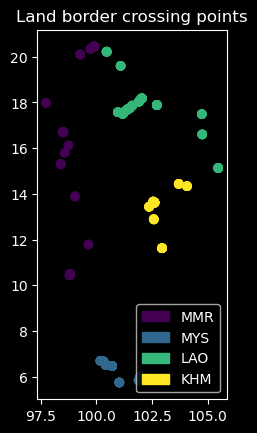

In [17]:
# plot THA land border crossing points for sanity

to_plot = importing_nodes
country_ints, labels = pd.factorize(to_plot["iso_a3"])
unique_country_ints = []
cmap = plt.get_cmap("viridis")
colours = [cmap(x) for x in country_ints / max(country_ints)]
[unique_country_ints.append(c) for c in colours if c not in unique_country_ints]
colour_map = dict(zip(labels, unique_country_ints))
f, ax = plt.subplots()
to_plot.plot(color=colours, ax=ax)
ax.set_title("Land border crossing points")
patches = [mpatches.Patch(color=colour, label=label) for label, colour in colour_map.items()]
ax.legend(handles=patches)

<Axes: >

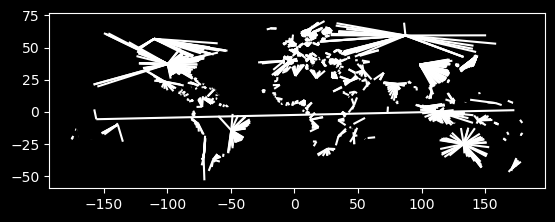

In [18]:
# connect foreign ports to their country with new edges

foreign_ports = maritime_nodes[maritime_nodes.infra=="port"]
foreign_ports = foreign_ports[foreign_ports.iso_a3 != study_country]
port_to_importing_countries_edges = create_edges_to_destination_countries(foreign_ports, destination_country_nodes)
port_to_importing_countries_edges.plot()

In [19]:
# now connect countries without a port (landlocked, typically), to their nearest (several) port(s)?

# ... turns out the only one of these seems to be Laos (LAO), but that's connected by land anyway

In [20]:
# add in edges connecting destination countries to THA land borders and foreign ports

edges = pd.concat(
    [
        edges.loc[:, edge_cols],
        duplicate_reverse_and_append_edges(land_border_to_importing_country_edges.loc[:, edge_cols]),
        duplicate_reverse_and_append_edges(port_to_importing_countries_edges.loc[:, edge_cols]),
    ]
).reset_index(drop=True)

# there are duplicate edges (repeated from_id -> to_id pairs), drop these here
edges["unique_edge_id"] = edges.apply(lambda row: f"{row.from_id}_{row.to_id}", axis=1)
edges = edges[~edges.unique_edge_id.duplicated(keep="first")].drop(columns=["unique_edge_id"])

In [26]:
# write out global multi-modal transport network to disk

save_dir = os.path.join(root_dir, "results/multi-modal_network/"
os.makedirs(save_dir, exist_ok=True)

# reset indicies to 0-start integers
# these will correspond to igraph's internal edge/vertex ids
nodes = nodes.reset_index(drop=True)
nodes.to_parquet(os.path.join(save_dir, "nodes.gpq"))
edges = edges.reset_index(drop=True)
edges.to_parquet(os.path.join(save_dir, "edges.gpq"))